Nome: Fabio Grassiotto

RA: 890441

Curso: IA901A

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')
data_dir = "gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset"

# Neptune
!pip install neptune
import neptune

Mounted at /content/gdrive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.6/442.6 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 82.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 9.2 MB/s eta 0:00:00


# Deep Learning para detecção de tumores no cérebro

In [2]:
# Imports

# import the needed libs

from __future__ import print_function, division

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

## Carregar dados

Este código carrega imagens 2D de cérebros saudáveis e cérebros contendo tumores usando um dataloader.

In [3]:
class ImageFolderWithPath(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target, path

In [4]:
# Data augmentation and normalization for training

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((170,170)),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize((170,170)),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize((170,170)),
        transforms.ToTensor()
    ])
}

image_datasets = {x: ImageFolderWithPath(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24, shuffle=True, num_workers=6) for x in ['train', 'val', 'test']}

# Train 143 (56,5%), Val 62 (24,5%), Test 48 (19%)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


device(type='cuda', index=0)

In [5]:
print(dataset_sizes)

{'train': 143, 'val': 62, 'test': 48}


# Visualizando algumas imagens (um batch)

Batch of training data


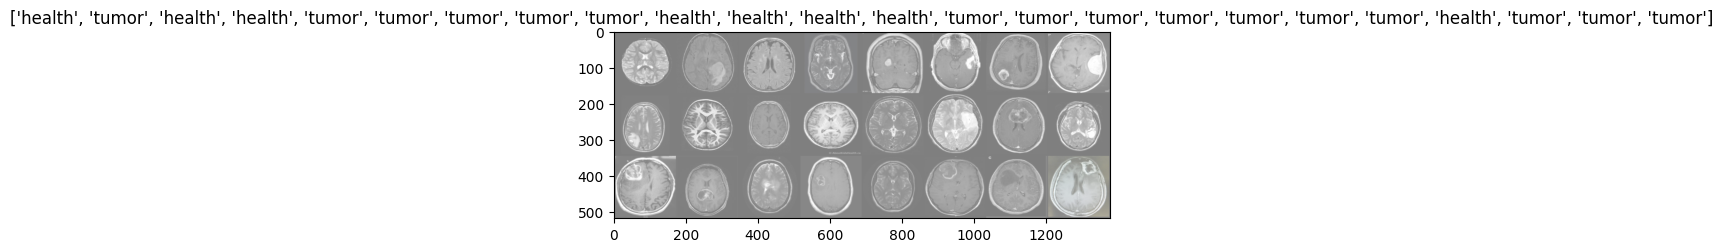

Batch of validation data


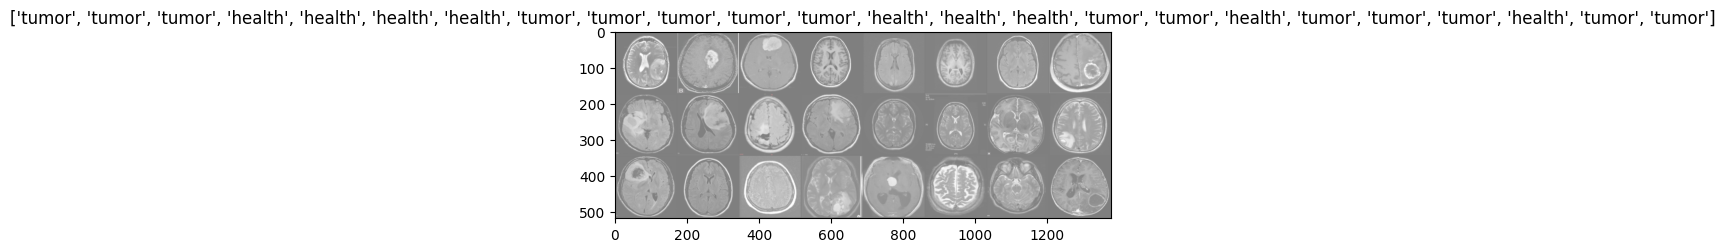

Batch of test data


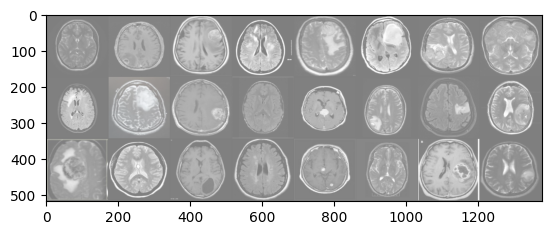

('gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test11.jpg', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test6.JPG', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test47.JPG', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test19.png', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test46.JPG', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test25.jpg', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test35.JPG', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test1.jpg', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test20.jpg', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test32.JPG', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test45.JPG', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/

In [6]:
#visualize
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


print('Batch of training data')
inputs, classes, _ = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


print('Batch of validation data')
inputs, classes, _ = next(iter(dataloaders['val']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])



print('Batch of test data')
inputs, _, paths = next(iter(dataloaders['test']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

print(paths)

# Treinando o modelo

In [7]:
from tqdm.notebook import tqdm

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs), total=num_epochs,
                              desc ="Epochs:"):
        #print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        #print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels, _ in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            #    phase, epoch_loss, epoch_acc))
            # Neptune Logging
            if phase == 'train':
              run["train/loss"].append(epoch_loss)
              run["train/accuracy"].append(epoch_acc)
            else:
              run["val/loss"].append(epoch_loss)
              run["val/accuracy"].append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            if phase == 'train':
                LOSS_train.append(epoch_loss)
                ACC_train.append(epoch_acc)
            if phase == 'val':
                LOSS_val.append(epoch_loss)
                ACC_val.append(epoch_acc)
        
        #print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


# Testando o modelo

In [8]:
def test_model(model, num_images=48):
    was_training = model.training
    model.eval()
    images_so_far = 0
    

    with torch.no_grad():
        for i, (inputs, _, paths) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                fig = plt.figure(figsize=(50, 50))
                plt.tight_layout() 
                plt.subplot(num_images, 1, images_so_far)
                plt.axis('off')
                print('path: {} / predicted: {}'.format(paths[j].split('/')[7], class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#### Visualizing the model predictions

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels, paths) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('path:{} predicted: {}'.format(paths[j].split('/')[7], class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Transfer Learning com EfficientNet

Utilizei aqui o modelo EfficientNet, conforme descrito em "EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks", https://arxiv.org/abs/1905.11946.

De acordo com a literatura, a família de modelos EfficientNets são apropriados para transfer learning e conseguem obter acurácia alta no CIFAR-100 (91.7%) e no Flowers (98.8%), entre outros datasets conhecidos. Selecionei o modelo baseline (B0) desta família e executei *Fine Tuning*, ou seja, alteração da camada de saída (para duas classes) e retreinamento do modelo com a nossa base de imagens.

Os gráficos incluídos da métrica de acurácia na base de validação foram gerados através do Neptune.ai.

In [10]:
from torchvision.models import efficientnet_b0

model_eff0 = models.efficientnet_b0(pretrained=True)
model_eff0.classifier[1] = nn.Linear(in_features= model_eff0.classifier[1].in_features, out_features=2)
model_eff0.eval().to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 89.3MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [11]:
# Transfer Learning, treinamento com a base existente

LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

model_eff0 = models.efficientnet_b0(pretrained=True)
model_eff0.classifier[1] = nn.Linear(in_features= model_eff0.classifier[1].in_features, out_features=2)
model_eff0.eval().to(device)

criterion = nn.CrossEntropyLoss()
optimizer_eff0 = optim.SGD(model_eff0.parameters(), lr=0.0008, momentum=0.9)
scheduler_eff0 = lr_scheduler.StepLR(optimizer_eff0, step_size=200, gamma=0.5)

run = neptune.init_run(
    project="fabiogr/Ex06-IA901",
    name="EfficientNet-B0",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlZjFhY2M5ZS05ZTc5LTQ0ZmItYThmOS02YTQ5OTZjNGEyNDkifQ==",
)

model_eff0 = train_model(model_eff0, criterion, optimizer_eff0, scheduler_eff0, num_epochs = 20)

run.stop()


<ipython-input-11-af003cb73989>:16: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/fabiogr/Ex06-IA901/e/EX-47


Epochs::   0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training complete in 0m 58s
Best val Acc: 0.870968
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
All 4 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/fabiogr/Ex06-IA901/e/EX-47/metadata


Curva de acurácia na base de validação:

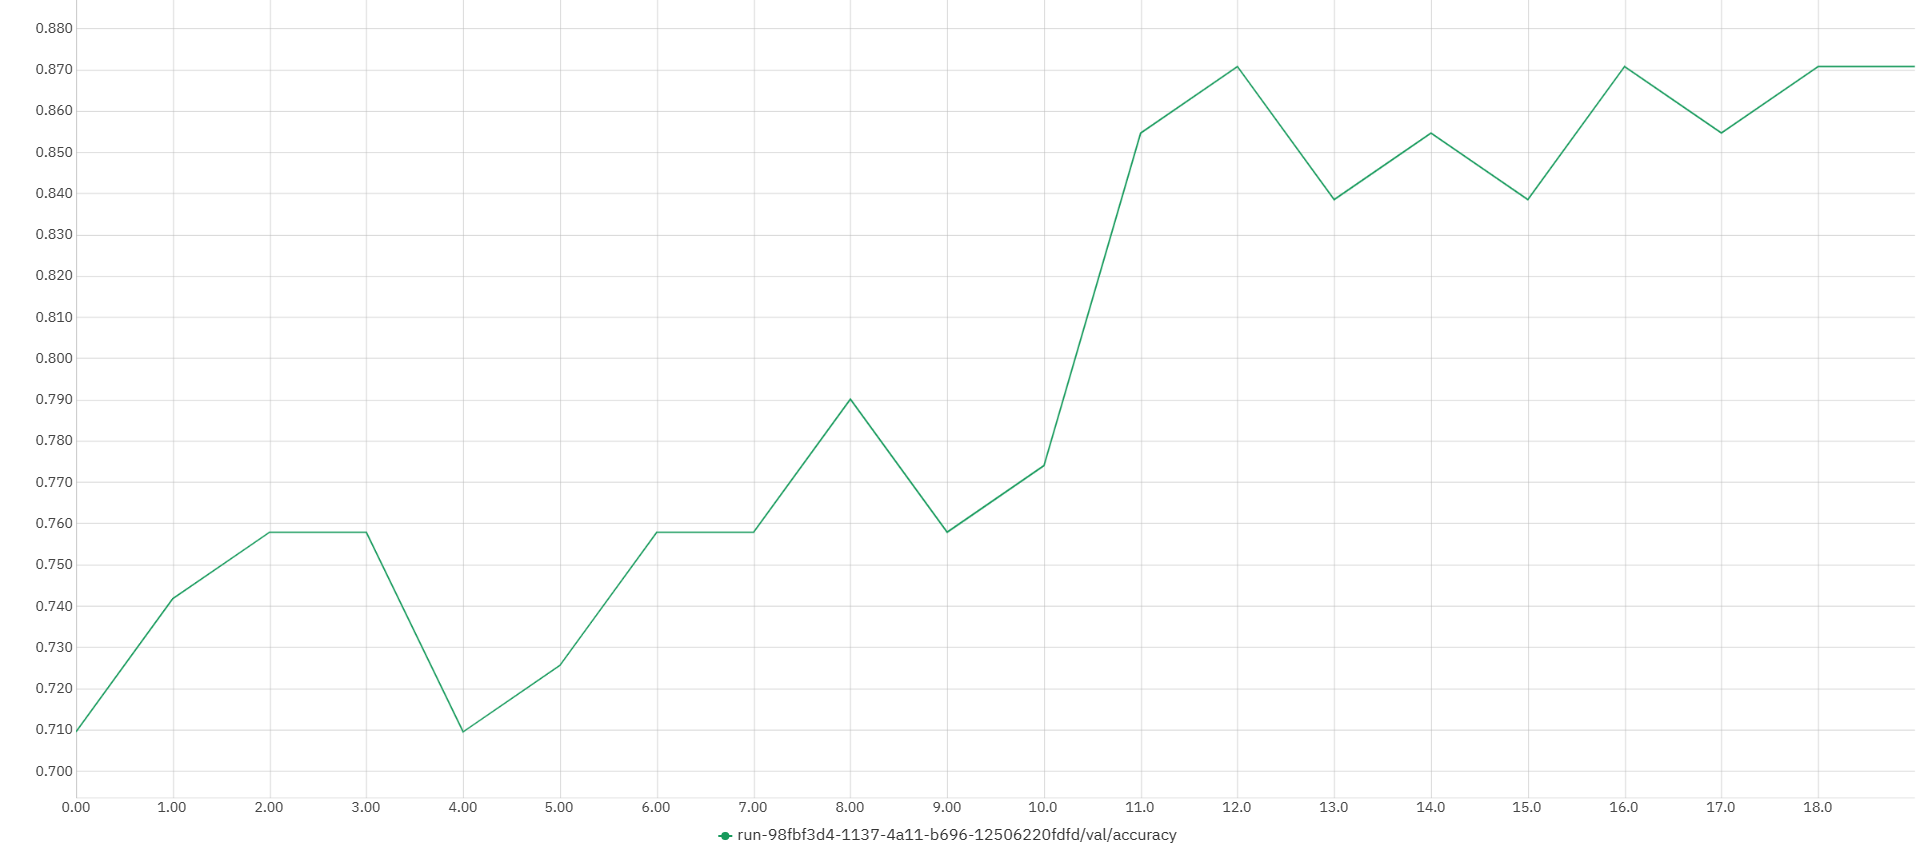

Notei que obtivemos uma acurácia na base de validação de cerca de **0.87**, com um ganho razoável em relação ao ResNet18.

#### Data Augmentation

O primeiro passo para melhorar a performance do modelo será a alteração das imagens de entrada através do processo de *data augmentation*. O Pytorch oferece algumas funcionalidades em sua biblioteca para a execução de transformações padrões de transformadas no carregamento das imagens.

In [12]:
data_transforms_aug = {
    # Só alterar a base de treinamento
    'train': transforms.Compose([
        transforms.Resize((170,170)),
        torchvision.transforms.RandomRotation((20,90)),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize((170,170)),
        torchvision.transforms.RandomRotation((20,90)),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize((170,170)),
        transforms.ToTensor()
    ])
}

# Dataset with Augmentation
def get_loader(phase):
  dataset_aug = ImageFolderWithPath(os.path.join(data_dir, phase), data_transforms_aug[phase])
  loader = torch.utils.data.DataLoader(dataset_aug, batch_size=24, shuffle=True, num_workers=2)
  return loader

dataloaders = { 'train': get_loader('train'),
                'val': get_loader('val'),
                'test': get_loader('test')}

LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

run = neptune.init_run(
    project="fabiogr/Ex06-IA901",
    name="EfficientNet-B0 com Augmentation",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlZjFhY2M5ZS05ZTc5LTQ0ZmItYThmOS02YTQ5OTZjNGEyNDkifQ==",
)

model_eff0 = models.efficientnet_b0(pretrained=True)
model_eff0.classifier[1] = nn.Linear(in_features= model_eff0.classifier[1].in_features, out_features=2)
model_eff0.eval().to(device)

criterion = nn.CrossEntropyLoss()
optimizer_eff0 = optim.SGD(model_eff0.parameters(), lr=0.0008, momentum=0.9)
scheduler_eff0 = lr_scheduler.StepLR(optimizer_eff0, step_size=200, gamma=0.5)
model_eff0 = train_model(model_eff0, criterion, optimizer_eff0, scheduler_eff0, num_epochs = 20)

run.stop()

https://app.neptune.ai/fabiogr/Ex06-IA901/e/EX-48


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epochs::   0%|          | 0/20 [00:00<?, ?it/s]

Training complete in 0m 35s
Best val Acc: 0.903226
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 12 operations to synchronize with Neptune. Do not kill this process.
All 12 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/fabiogr/Ex06-IA901/e/EX-48/metadata


Efetuamos a rotação aleatória de algumas das imagens de entrada, usando a transformação RandomRotation() do Pytorch, chegando ao valor de acurácia de **0.90** na base de validação, portanto um pouco mais alta do que sem a rotação. Esta operação é interessante pois aumenta a capacidade de generalização do modelo.

Curva de acurácia na base de validação:

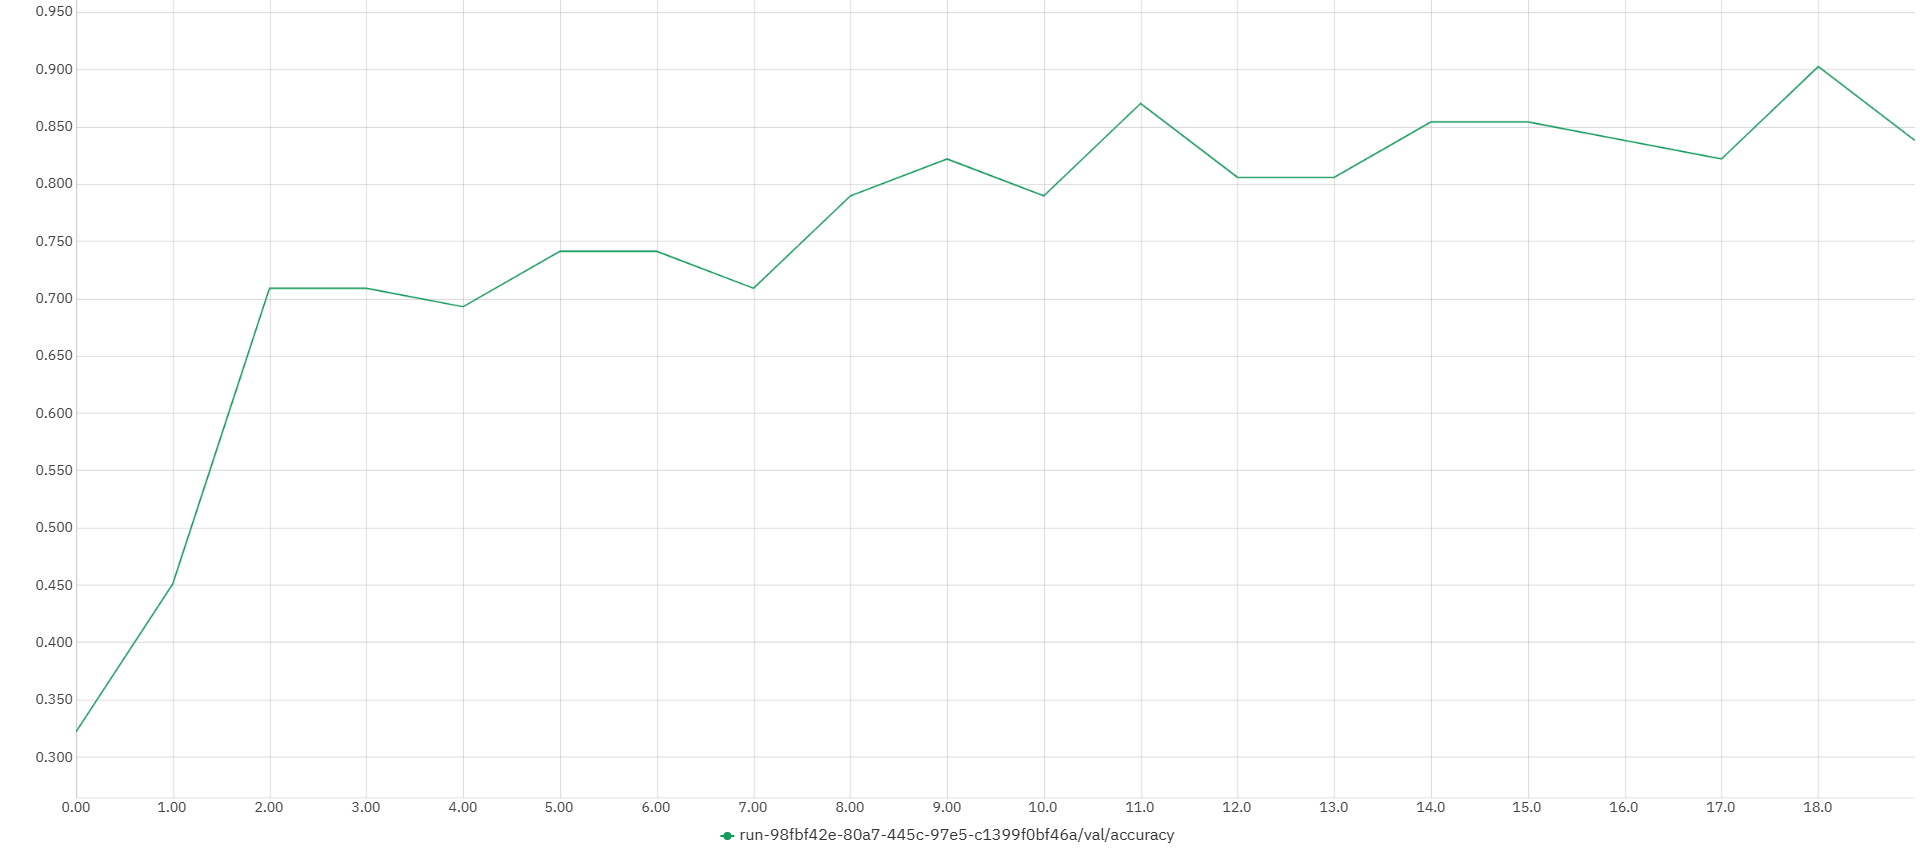

#### Modificação de hyperparâmetros

##### 1. Taxa de aprendizado

Executei novos treinamentos do modelo variando a ordem de grandeza da taxa de aprendizado.

In [13]:
for lrate in [0.00008, 0.0008, 0.008]:

  LOSS_train = []
  LOSS_val = []
  ACC_train = []
  ACC_val = []

  print('Learning Rate =', lrate)
  
  run = neptune.init_run(
    project="fabiogr/Ex06-IA901",
    name="EfficientNet-B0 Learning Rate =" + str(lrate),
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlZjFhY2M5ZS05ZTc5LTQ0ZmItYThmOS02YTQ5OTZjNGEyNDkifQ==",
  )

  model_eff0 = models.efficientnet_b0(pretrained=True)
  model_eff0.classifier[1] = nn.Linear(in_features= model_eff0.classifier[1].in_features, out_features=2)
  model_eff0.eval().to(device)
  
  criterion = nn.CrossEntropyLoss()
  optimizer_eff0 = optim.SGD(model_eff0.parameters(), lr=lrate, momentum=0.9)
  scheduler_eff0 = lr_scheduler.StepLR(optimizer_eff0, step_size=200, gamma=0.5)
  model_eff0 = train_model(model_eff0, criterion, optimizer_eff0, scheduler_eff0, num_epochs = 20)

  run.stop()


Learning Rate = 8e-05
https://app.neptune.ai/fabiogr/Ex06-IA901/e/EX-49


Epochs::   0%|          | 0/20 [00:00<?, ?it/s]

Training complete in 0m 37s
Best val Acc: 0.758065
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
All 4 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/fabiogr/Ex06-IA901/e/EX-49/metadata
Learning Rate = 0.0008
https://app.neptune.ai/fabiogr/Ex06-IA901/e/EX-50


Epochs::   0%|          | 0/20 [00:00<?, ?it/s]

Training complete in 0m 37s
Best val Acc: 0.903226
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
All 2 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/fabiogr/Ex06-IA901/e/EX-50/metadata
Learning Rate = 0.008
https://app.neptune.ai/fabiogr/Ex06-IA901/e/EX-51


Epochs::   0%|          | 0/20 [00:00<?, ?it/s]

Training complete in 0m 36s
Best val Acc: 0.951613
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 14 operations to synchronize with Neptune. Do not kill this process.
All 14 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/fabiogr/Ex06-IA901/e/EX-51/metadata


A acurácia obtida na base de validação foi mais alta para o menor valor da taxa de aprendizado, de cerca de **0.95**.
Na comparação abaixo podemos visualizar essa tendência.

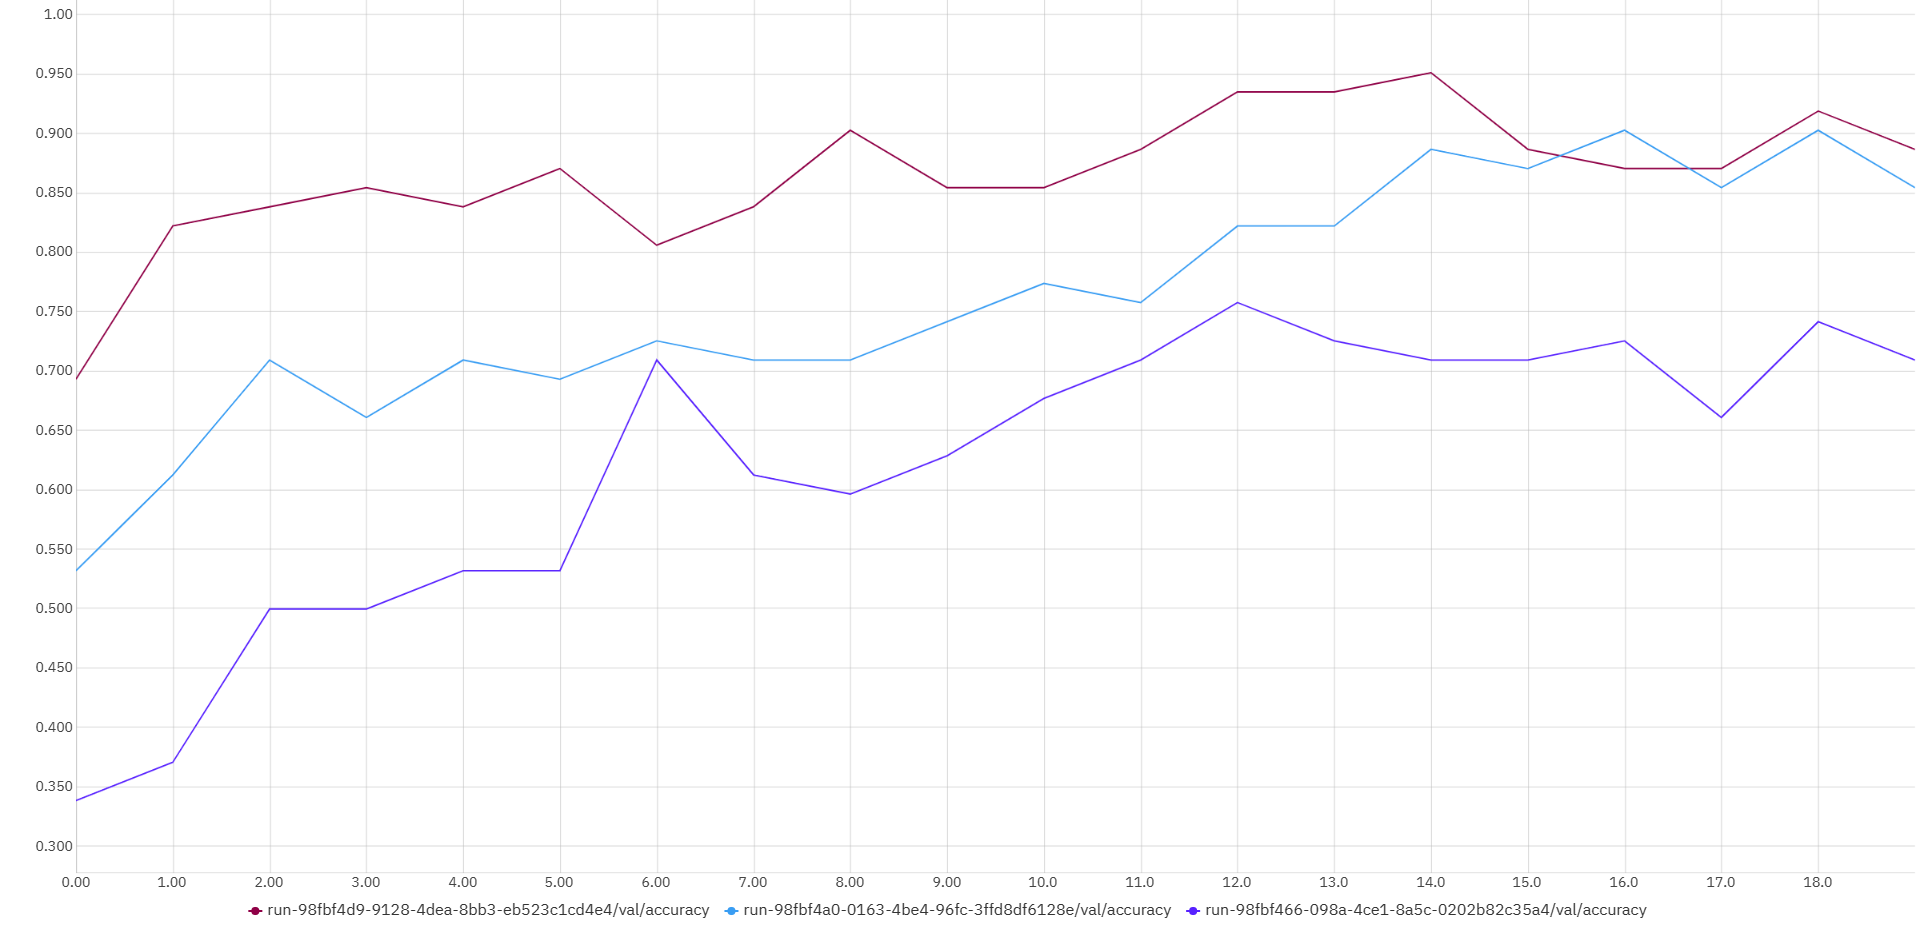

##### 2. Número de épocas

A seguir o número de épocas foi avaliado com três novas execuções do treinamento na base.

In [14]:
for epochs in [20, 50, 100]:

  LOSS_train = []
  LOSS_val = []
  ACC_train = []
  ACC_val = []

  print("\nNúmero de épocas = ", epochs)
  print()

  lrate = 0.008
  
  run = neptune.init_run(
    project="fabiogr/Ex06-IA901",
    name="EfficientNet-B0 Num Epochs =" + str(epochs),
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlZjFhY2M5ZS05ZTc5LTQ0ZmItYThmOS02YTQ5OTZjNGEyNDkifQ==",
  )

  model_eff0 = models.efficientnet_b0(pretrained=True)
  model_eff0.classifier[1] = nn.Linear(in_features= model_eff0.classifier[1].in_features, out_features=2)
  model_eff0.eval().to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer_eff0 = optim.SGD(model_eff0.parameters(), lr=lrate, momentum=0.9)
  scheduler_eff0 = lr_scheduler.StepLR(optimizer_eff0, step_size=200, gamma=0.5)
  model_eff0 = train_model(model_eff0, criterion, optimizer_eff0, scheduler_eff0, num_epochs = epochs)

  run.stop()


Número de épocas =  20

https://app.neptune.ai/fabiogr/Ex06-IA901/e/EX-52


Epochs::   0%|          | 0/20 [00:00<?, ?it/s]

Training complete in 0m 37s
Best val Acc: 0.903226
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
All 4 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/fabiogr/Ex06-IA901/e/EX-52/metadata

Número de épocas =  50

https://app.neptune.ai/fabiogr/Ex06-IA901/e/EX-53


Epochs::   0%|          | 0/50 [00:00<?, ?it/s]

Training complete in 1m 42s
Best val Acc: 0.967742
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
All 4 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/fabiogr/Ex06-IA901/e/EX-53/metadata

Número de épocas =  100

https://app.neptune.ai/fabiogr/Ex06-IA901/e/EX-54


Epochs::   0%|          | 0/100 [00:00<?, ?it/s]

Training complete in 3m 10s
Best val Acc: 0.935484
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 6 operations to synchronize with Neptune. Do not kill this process.
All 6 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/fabiogr/Ex06-IA901/e/EX-54/metadata


Nota-se que a maior acurácia, de **0.97** foi obtida treinando o modelo em 50 épocas. Na análise do gráfico comparativo abaixo, podemos notar que não existe ganho no treinamento acima desse número de épocas.

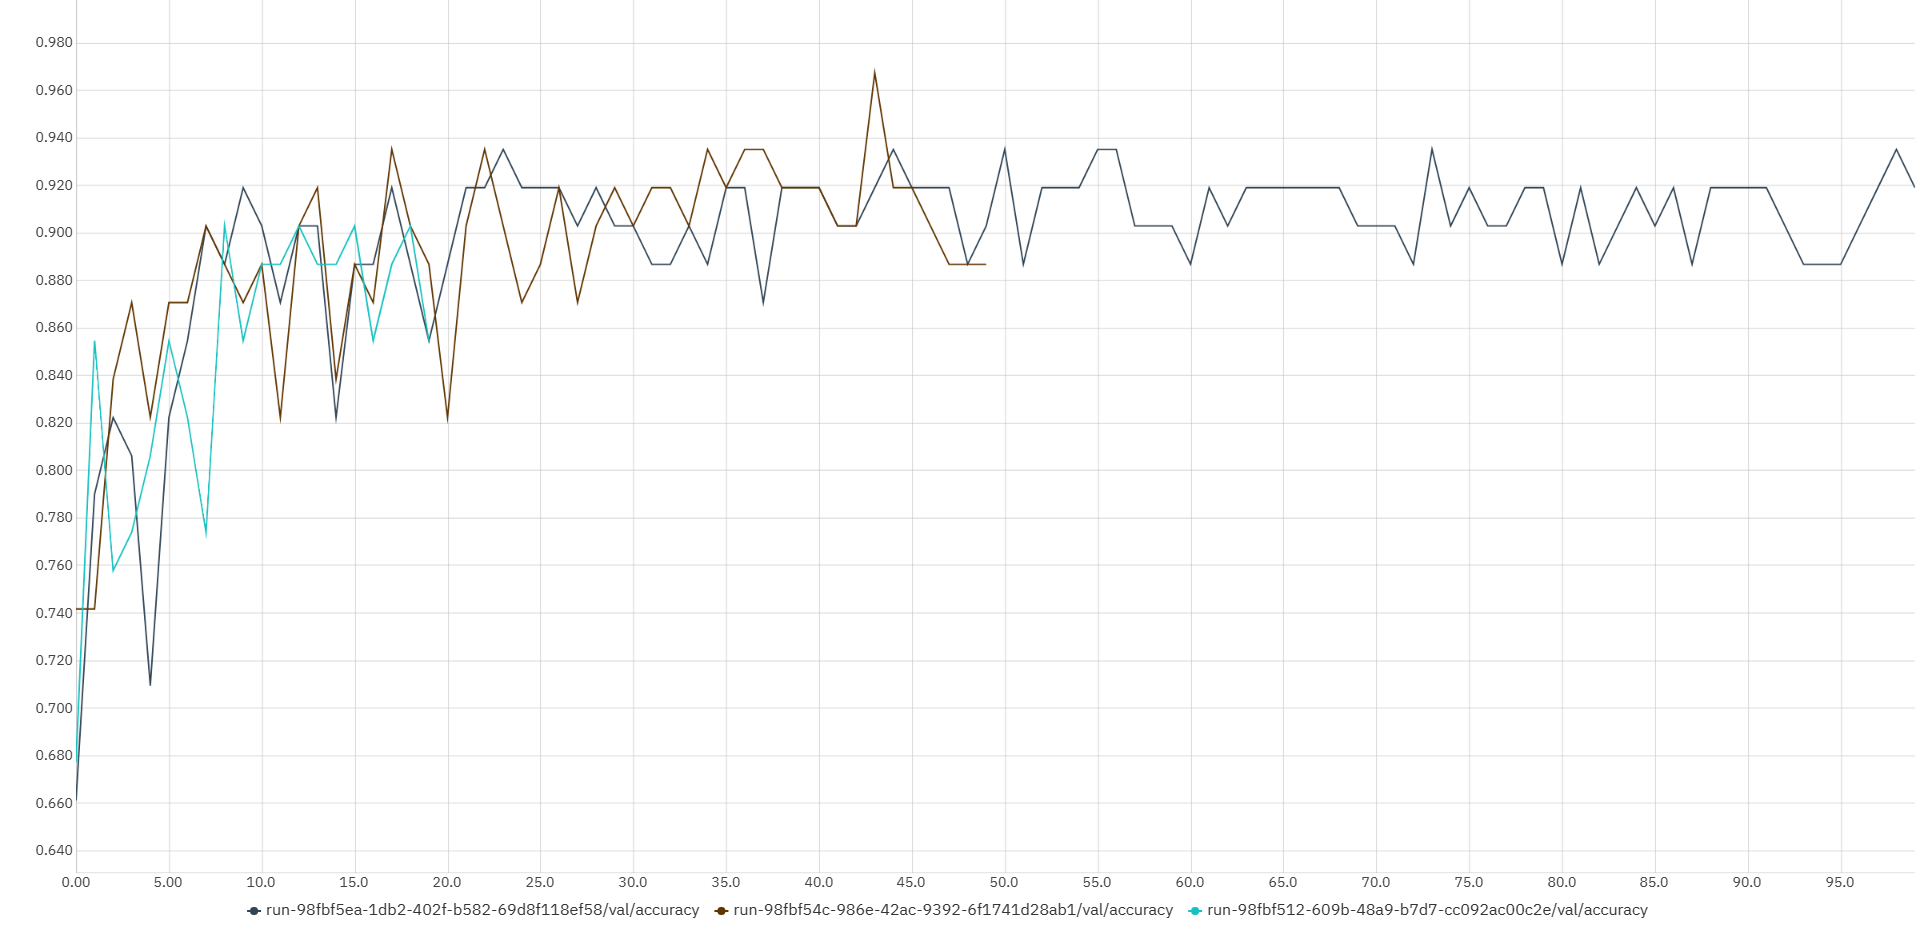

#### Execução do melhor modelo na base de testes:

Utilizando os melhores híper-parâmetros obtidos acima, executamos a classificação da base de testes. Os resultados abaixo foram reordenados para a entrega do exercício.

In [18]:
def test_model_print(model, num_images=48):
    was_training = model.training
    model.eval()
    images_so_far = 0
    

    with torch.no_grad():
        for i, (inputs, _, paths) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                print('{} {}'.format(paths[j].split('/')[7], class_names[preds[j]]))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Melhores híper-parâmetros:
lrate = 0.008
epochs = 50

run = neptune.init_run(
    project="fabiogr/Ex06-IA901",
    name="EfficientNet-B0 Best Model",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlZjFhY2M5ZS05ZTc5LTQ0ZmItYThmOS02YTQ5OTZjNGEyNDkifQ==",
  )

model_eff0 = models.efficientnet_b0(pretrained=True)
model_eff0.classifier[1] = nn.Linear(in_features= model_eff0.classifier[1].in_features, out_features=2)
model_eff0.eval().to(device)

criterion = nn.CrossEntropyLoss()
optimizer_eff0 = optim.SGD(model_eff0.parameters(), lr=lrate, momentum=0.9)
scheduler_eff0 = lr_scheduler.StepLR(optimizer_eff0, step_size=200, gamma=0.5)
model_eff0 = train_model(model_eff0, criterion, optimizer_eff0, scheduler_eff0, num_epochs = epochs)

run.stop()

test_model_print(model_eff0)

https://app.neptune.ai/fabiogr/Ex06-IA901/e/EX-55


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epochs::   0%|          | 0/50 [00:00<?, ?it/s]

Training complete in 1m 31s
Best val Acc: 0.935484
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 8 operations to synchronize with Neptune. Do not kill this process.
All 8 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/fabiogr/Ex06-IA901/e/EX-55/metadata
test1.jpg tumor
test19.png health
test17.jpeg health
test43.JPG tumor
test25.jpg tumor
test22.jpg tumor
test40.JPG tumor
test14.jpg health
test44.JPG tumor
test34.JPG health
test4.jpg tumor
test45.JPG tumor
test16.jpg health
test33.JPG tumor
test32.JPG tumor
test10.JPG health
test48.JPG tumor
test36.JPG tumor
test41.jpg tumor
test46.JPG tumor
test2.jpg health
test47.JPG tumor
test39.JPG health
test9.JPG tumor
test15.jpeg health
test29.JPG tumor
test6.JPG tumor
test12.jpg health
test35.JPG tumor
test23.jpeg health
test26.jpg tumor
test18.jpg health
test27.jpg tumor
test31.JPG tumor
test20.jpg health
test5.jpg tumor
test38.JPG tumor
test3.jpg 